In [1]:
import csv_to_sqlite 
import sqlite3
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
 # visualizing pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

pd.set_option('display.max_columns', None)

/Users/nfrate/.pyenv/versions/3.8.12/envs/airbnb_advice/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data preparation

In [2]:
# Load data
df = pd.read_csv('../raw_data/listings.csv')

# No needed columns
columns_todrop = ['id',
                  'listing_url',
                  'scrape_id',
                  'name',
                  'description',
                  'neighborhood_overview',
                  'picture_url',
                  'host_id',
                  'host_url',
                  'host_name',
                  'host_location',
                  'host_about',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_verifications',
                  'neighbourhood',
                  'neighbourhood_group_cleansed',
                  'calendar_last_scraped',
                  'bathrooms',
                  'calendar_updated',
                  'license',
                  'host_response_time',
                  'host_response_rate',
                  'host_acceptance_rate',
                  'bathrooms_text',
                  'host_neighbourhood',
                  'last_review'
                 ]
df = df.drop(columns=columns_todrop)

# Converting Amenities from str to list
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['total_amenities'] = df['amenities'].apply(lambda x: len(x))

# Droping null - subset: host since 
df.dropna(subset=['host_since'],inplace=True)

# Formating to datetime
df[['host_since','first_review','last_scraped']] = df[['host_since','first_review','last_scraped']].apply(pd.to_datetime)

# Calculating Host Tenure
df['host_tenure'] = (df['last_scraped'] - df['host_since']).dt.days

# Formating Price
df['price'] = df['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

# Reseting Index
df.reset_index(drop=True,inplace=True)


## Basic Model

In [3]:
# Set of columns for a basic model
reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns]
df_reg.head(5)

,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,neighbourhood_cleansed,price
0,51.56861,-0.11270,Private room,2,1.0,NaN,1,Islington,65.0
1,51.48780,-0.16813,Entire home/apt,2,1.0,1.0,3,Kensington and Chelsea,75.0
2,51.52195,-0.14094,Entire home/apt,6,3.0,3.0,4,Westminster,265.0
3,51.47935,-0.19743,Private room,2,1.0,1.0,3,Hammersmith and Fulham,150.0
4,51.57438,-0.21081,Private room,2,1.0,NaN,10,Barnet,29.0


In [4]:
# Total percent Nulls values
df_reg.isnull().sum()/len(df_reg)*100

latitude                  0.000000
longitude                 0.000000
room_type                 0.000000
accommodates              0.000000
bedrooms                  6.024151
beds                      5.466943
minimum_nights            0.000000
neighbourhood_cleansed    0.000000
price                     0.000000
dtype: float64

### Basic Model Pipeline

In [5]:
X = df_reg.drop(columns='price')
y = df_reg['price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('encoding', cat_transformer, ['room_type','neighbourhood_cleansed']),
    ('imputer', KNNImputer(missing_values=np.nan),['bedrooms','beds'])],
    remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model',LinearRegression())
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('imputer', KNNImputer(),
                                                  ['bedrooms', 'beds'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

### Basic Model Scoring

In [8]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)

print('Scoring with Train data')
print(f'R2 Score: {pipe.score(X_train,y_train)}')
print(f'RMSE: {mean_squared_error(y_train, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_train, y_pred)}')

Scoring with Train data
R2 Score: 0.07874037369689924
RMSE: 315.107607763427
MAE: 88.77831432236017


In [9]:
y_pred = pipe.predict(X_test)
print('Scoring with Test data')

print(f'R2 Score: {pipe.score(X_test,y_test)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

Scoring with Test data
R2 Score: 0.056744042530647354
RMSE: 384.7592592874731
MAE: 93.96510950454409


### Basic Model pickle file

In [10]:
import pickle

# Export pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipe, file )

## Model Tuning Exploration 

### Correlations with Price

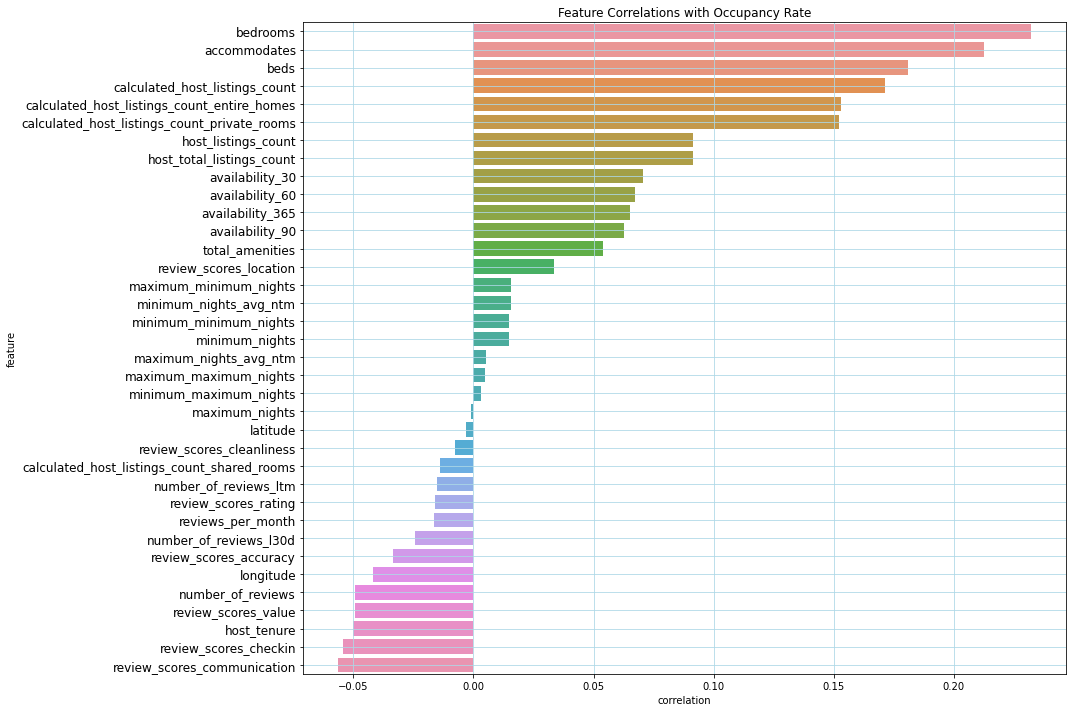

In [11]:
or_corr = pd.DataFrame(df.corrwith(df['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Occupancy Rate', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

### Model with Feature encoding

In [12]:
reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns].copy()

# Imputing Bedrooms and Beds
imputer_bedroom = KNNImputer(missing_values=np.nan)
imputer_bed = KNNImputer(missing_values=np.nan)

df_reg['bedrooms'] = imputer_bedroom.fit_transform(df[['bedrooms']])
df_reg['beds'] = imputer_bed.fit_transform(df[['beds']])

# Feature Encoding
# ------------------------------------------------------

# Room Type
encoder_room_type = OneHotEncoder(sparse=False)
room_type_encoded = pd.DataFrame(encoder_room_type.fit_transform(df_reg[['room_type']]))
room_type_encoded.columns=[x.replace(' ','_').replace('/','_') for x in encoder_room_type.categories_[0].tolist()]

# Neighbourhood
encoder_neighbourhood = OneHotEncoder(sparse=False)
neighbourhood_encoded = pd.DataFrame(encoder_neighbourhood.fit_transform(df_reg[['neighbourhood_cleansed']]))
neighbourhood_encoded.columns=[x.replace(' ','_') for x in encoder_neighbourhood.categories_[0].tolist()]

# Concatenating encoded dataframes 
df_reg = pd.concat([df_reg, room_type_encoded, neighbourhood_encoded], axis=1)
df_reg.drop(columns=['room_type','neighbourhood_cleansed'], inplace=True)

df_reg.head(5)

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,price,Entire_home_apt,Hotel_room,Private_room,Shared_room,Barking_and_Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City_of_London,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith_and_Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington_and_Chelsea,Kingston_upon_Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond_upon_Thames,Southwark,Sutton,Tower_Hamlets,Waltham_Forest,Wandsworth,Westminster
0,51.56861,-0.11270,2,1.0,1.758031,1,65.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,51.48780,-0.16813,2,1.0,1.000000,3,75.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.52195,-0.14094,6,3.0,3.000000,4,265.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,51.47935,-0.19743,2,1.0,1.000000,3,150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51.57438,-0.21081,2,1.0,1.758031,10,29.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Correlations with Encoded Features

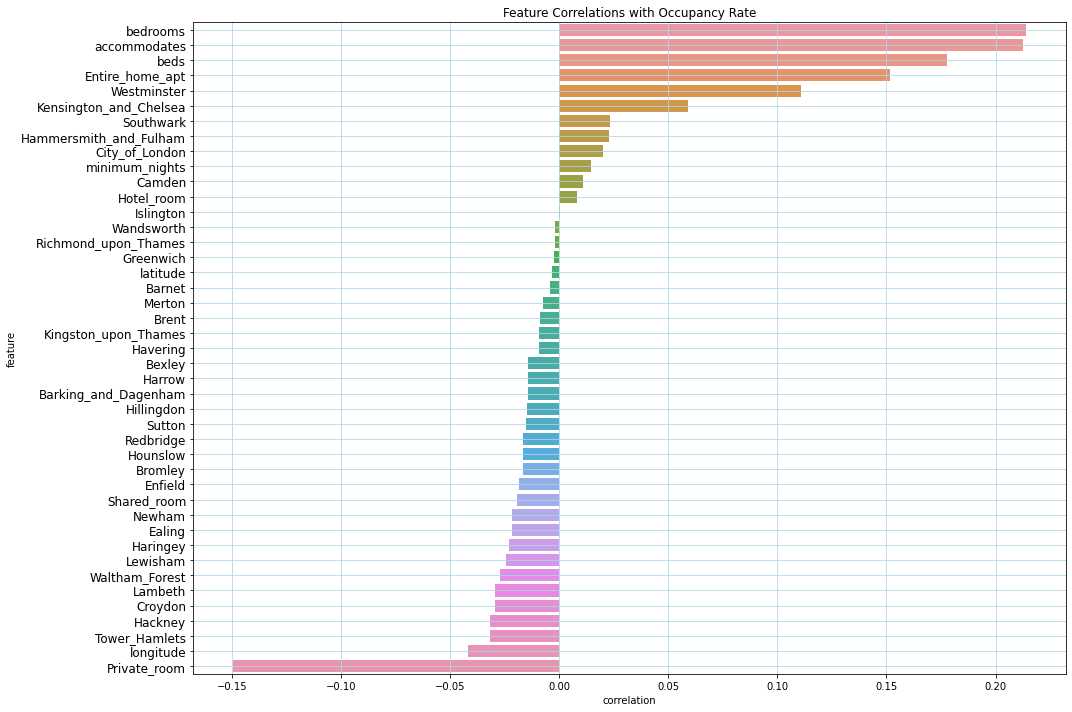

In [13]:
or_corr = pd.DataFrame(df_reg.corrwith(df_reg['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Occupancy Rate', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

#### Linear Model OSL

In [14]:
scaler = StandardScaler()
df_reg_scaled = pd.DataFrame(scaler.fit_transform(df_reg), columns=list(df_reg.columns))

In [15]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [16]:
model = smf.ols(formula = formula_from_cols(df_reg_scaled,'price'), data=df_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     125.9
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:17:39   Log-Likelihood:            -4.8203e+05
No. Observations:               66582   AIC:                         9.641e+05
Df Residuals:                   66540   BIC:                         9.645e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5245.7167   3527.603     -1.487      0.137   -1.22e+04    1668.385
latitude                 130.3674     87.702      1.486      0.137     -41.529     302.264
longitude                 54.2520     54.087      1.003      0.316     -51.759     160.263
accommodates              16.0523      1.408     11.403      0.000      13.293      18.811
bedrooms                  57.6022      2.754     20.912      0.000      52.203      63.001
beds                      -4.4191      1.965     -2.249      0.024      -8.270      -0.568
minimum_nights             0.1885      0.043      4.359      0.000       0.104       0.273
Entire_home_apt        -1300.3470    881.952     -1.474      0.140   -3028.972     428.278
Hotel_room             -1282.9505    882.021     -1.455      0.146   -3011.711     445.810
Private_room           -1317.1923    881.961     -1.493      0.135   -3045.836     411.452
Shared_room            -1345.2267    881.961     -1.525      0.127   -3073.870     383.417
Barking_and_Dagenham    -207.4881    113.535     -1.828      0.068    -430.016      15.040
Barnet                  -153.8571    114.842     -1.340      0.180    -378.947      71.233
Bexley                  -210.2472    108.119     -1.945      0.052    -422.160       1.666
Brent                   -157.6568    110.336     -1.429      0.153    -373.915      58.601
Bromley                 -186.8002     99.634     -1.875      0.061    -382.083       8.483
Camden                  -129.4055    109.689     -1.180      0.238    -344.397      85.586
City_of_London           -38.4456    109.211     -0.352      0.725    -252.499     175.608
Croydon                 -185.2682     96.915     -1.912      0.056    -375.222       4.686
Ealing                  -169.7390    107.318     -1.582      0.114    -380.082      40.604
Enfield                 -212.1010    119.296     -1.778      0.075    -445.922      21.720
Greenwich               -148.9486    106.611     -1.397      0.162    -357.906      60.009
Hackney                 -178.0184    110.955     -1.604      0.109    -395.491      39.454
Hammersmith_and_Fulham  -104.1655    105.305     -0.989      0.323    -310.564     102.233
Haringey                -194.0861    114.436     -1.696      0.090    -418.381      30.209
Harrow                  -185.1939    114.680     -1.615      0.106    -409.967      39.579
Havering                -221.7982    117.741     -1.884      0.060    -452.570       8.973
Hillingdon              -168.1272    108.852     -1.545      0.122    -381.478      45.223
Hounslow                -162.6508    104.234     -1.560      0.119    -366.949      41.648
Islington               -138.0118    110.574     -1.248      0.212    -354.736      78.713
Kensington_and_Chelsea   -68.2243    106.141     -0.643      0.520    -276.261  

In [17]:
round(model.pvalues,5).sort_values()

accommodates              0.00000
bedrooms                  0.00000
minimum_nights            0.00001
beds                      0.02450
Bexley                    0.05183
Waltham_Forest            0.05321
Croydon                   0.05593
Havering                  0.05960
Bromley                   0.06082
Barking_and_Dagenham      0.06762
Sutton                    0.07461
Enfield                   0.07542
Redbridge                 0.07546
Lewisham                  0.08719
Haringey                  0.08989
Newham                    0.09168
Lambeth                   0.10074
Kingston_upon_Thames      0.10444
Harrow                    0.10634
Hackney                   0.10863
Ealing                    0.11374
Hounslow                  0.11866
Tower_Hamlets             0.12140
Hillingdon                0.12246
Shared_room               0.12720
Private_room              0.13532
Merton                    0.13680
Intercept                 0.13701
latitude                  0.13716
Entire_home_ap

#### Testing Different Models

In [18]:
model_lg = LinearRegression()
model_knn = KNeighborsRegressor()
model_sgd = SGDRegressor()
model_xg = XGBRegressor()
model_rf = RandomForestRegressor()

In [25]:
# GridSearch Parameters
# Initiaze the hyperparameters for each model
param_lg = {}
param_lg['scaler'] = [StandardScaler(),MinMaxScaler()]
param_lg['model'] = [model_lg]

param_knn = {}
param_knn['scaler'] = [StandardScaler(),MinMaxScaler()]
param_knn['model__n_neighbors'] = [1,3,5,7,10,15]
param_knn['model'] = [model_knn]

param_sgd = {}
param_sgd['scaler'] = [StandardScaler(),MinMaxScaler()]
param_sgd['model__loss'] = ['squared_error','huber']
param_sgd['model__learning_rate'] = ['constant','optimal','invscaling']
param_sgd['model'] = [model_sgd]

param_xg={}
param_xg['model__booster'] = ['gbtree','gblinear']
param_xg['model__learning_rate'] = [0.3,0.1,0.001]
param_xg['model__max_depth'] = [2,4,6]
param_xg['model'] = [model_xg]

param_rf={}
param_rf['model__max_depth'] = [2,4,6]
param_rf['model__n_estimators'] = [5,10,20,50,100]
param_rf['model'] = [model_rf]


params = [param_lg,param_knn,param_sgd,param_xg,param_rf]

In [26]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('model',model_rf)
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor())])

In [27]:
X = df_reg.drop(columns='price')
y = df_reg['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
%%time
# Train the grid search model
scoring=['neg_mean_absolute_error','r2']
gs = GridSearchCV(pipe, params, cv=3, n_jobs=-1, scoring='r2')
gs.fit(X_train, y_train)

CPU times: user 1.08 s, sys: 1.18 s, total: 2.25 s
Wall time: 5min 3s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()],
                          'scaler': [StandardScaler(), MinMaxScaler()]},
                         {'model': [KNeighborsRegressor(n_neighbors=7)],
                          'model__n_neighbors': [1, 3, 5, 7, 10, 15],
                          'scaler': [StandardScaler(), MinMaxScaler()]},
                         {'model': [SGDRegres...
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None,
                                                 scale_pos_weight=None,
                                                 subsample=None,
                                                 tree_method=None,
                                                 validate_parameters=None,
                                                 verbosity=None)],
                          'model__booster': ['gbtree', 'gblinear'],
                          'model__learning_rate': [0.3, 0.1, 0.001],
                          'model__max_depth': [2, 4, 6]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 4, 6],
                          'model__n_estimators': [5, 10, 20, 50, 100]}],
             scoring='r2')

In [29]:
gs.best_params_

{'model': KNeighborsRegressor(n_neighbors=7),
 'model__n_neighbors': 7,
 'scaler': StandardScaler()}

In [30]:
gs.best_score_

0.2530236032787124

In [31]:
gs.score(X_train, y_train)

0.45687525633577175

In [32]:
gs.score(X_test, y_test)

0.29653918643844457

In [33]:
y_pred = gs.predict(X_test)
print('Scoring with Test data')

print(f'R2 Score: {gs.score(X_test,y_test)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

Scoring with Test data
R2 Score: 0.29653918643844457
RMSE: 332.272390963549
MAE: 74.24485607008761
